In [5]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import torchvision
import torchvision.transforms as transforms

In [8]:
mnist_train = torchvision.datasets.FashionMNIST(root='Datasets', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='Datasets', train=False, download=True, transform=transforms.ToTensor())

batch_size = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [9]:
num_inputs = 784 # 28 * 28
num_outputs = 10

class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    # x shape: (batch, 1, 28, 28)
    def forward(self, x):
        y = self.linear(x.view(x.shape[0], -1))
        return y

net = LinearNet(num_inputs, num_outputs)

In [11]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
num_epochs = 5

def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

def train(net, train_iter, test_iter, loss, num_epochs, batch_size,
              params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()

            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            if optimizer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                optimizer.step()  # “softmax回归的简洁实现”一节将用到


            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.752, test acc 0.768
epoch 2, loss 0.0022, train acc 0.813, test acc 0.810
epoch 3, loss 0.0021, train acc 0.825, test acc 0.816
epoch 4, loss 0.0020, train acc 0.833, test acc 0.820
epoch 5, loss 0.0019, train acc 0.837, test acc 0.817


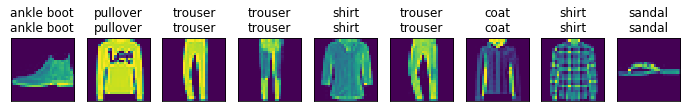

In [16]:
from utils import get_fashion_mnist_labels, show_fashion_mnist

X, y = iter(test_iter).next()

true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).detach().numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

show_fashion_mnist(X[0:9], titles[0:9])